In [1]:
import os
import shutil
import tempfile
import pandas as pd
import time

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import monai
from monai.utils import set_determinism, first
from monai.transforms import *

from monai.config import print_config
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric

from monai.data import (
    DataLoader,
    Dataset,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

from skimage import measure
from sklearn.metrics import roc_auc_score

import torch
import glob
print_config()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


MONAI version: 1.3.0
Numpy version: 1.24.4
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/anaconda3/envs/hwasan/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.21.0
scipy version: 1.10.1
Pillow version: 10.0.0
Tensorboard version: 2.14.0
gdown version: 4.7.1
TorchVision version: 0.15.2+cu117
tqdm version: 4.66.1
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.0.3
einops version: 0.6.1
transformers version: 4.21.3
mlflow version: 2.6.0
pynrrd version: 1.0.0
clearml version: 1.12.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
data_Root = os.path.normpath('/mnt/babymri/data')
logdir_path = os.path.normpath('log_test20220830_seg')
if os.path.exists(logdir_path)==False:
    os.mkdir(logdir_path)

In [3]:
path = "/home/oem/hufsbaby/joon/Brain_segmentation_0731/wmbg_c_v0731.csv"
df = pd.read_csv(path)
df

,Folder,Property,Sex,Days,Birth,Time,Unnamed: 6
0,1,Train,M,008D,2021-04-13,2021-04-21 10:05,NaN
1,4,Train,F,008D,2021-04-14,2021-04-22 15:43,NaN
2,7,Train,M,009D,2021-04-20,2021-04-29 9:59,NaN
3,8,Train,F,005D,2021-04-25,2021-04-30 10:29,NaN
4,10,Train,M,010D,2021-04-26,2021-05-06 15:11,NaN
5,12,Train,M,011D,2021-04-30,2021-05-11 10:07,NaN
6,13,Train,F,027D,2021-04-15,2021-05-12 10:23,NaN
7,17,Train,F,001M,2021-04-12,2021-05-27 10:02,NaN
8,20,Train,F,014D,2021-05-18,2021-06-01 15:36,NaN
9,21,Train,F,006D,2021-05-28,2021-06-03 10:05,NaN


In [4]:
# no_numbers = [10,11,15,43,45] + [44,46,47,48,49]
# valid_list = [10,11,15,43,45]
# test_list = [44,46,47,48,49]

# input_list = [i for i in range(len(df))if i not in no_numbers]
# print(input_list)

In [5]:
no_numbers = [40,41,42,43,44,45,46,47,48,49] + [0,1,2,3,4,5,6,7]
valid_list = [0,1,2,3,4,5,6,7]
# test_list = [44,46,47,48,49]

input_list = [i for i in range(len(df))if i not in no_numbers]
print(input_list)

[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


In [6]:
df_idx = df.index
df_idx_list = df.index.to_list()
df_idx_list

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49]

In [7]:
input_RT = []
for i in df_idx_list:
    p = df.iloc[i,0]
    if i in input_list:
        input_RT.append(f'{p:03d}') # 03d : 숫자를 세 자리로 표현하되, 빈 자리는 0으로 채우기

input_RV = []
for i in df_idx_list:
    p = df.iloc[i,0]
    if i in valid_list:
        input_RV.append(f'{p:03d}')

print(input_RT[:15])
print(input_RV[:])

['020', '021', '023', '026', '034', '036', '040', '057', '059', '061', '063', '069', '070', '071', '072']
['001', '004', '007', '008', '010', '012', '013', '017']


In [8]:
train_data = [
    {
        "image1": os.path.join(data_Root,str(idx)+'/'+
                                    "T2_r1.nii.gz"),
        "image2": os.path.join(data_Root,str(idx)+'/'+
                                    "SWI_M_mean_r1.nii.gz"),        
        "seg": os.path.join(data_Root,str(idx)+'/'+
                                    "wmbg_cx.nii.gz"),            
    }
    for idx in input_RT
]

val_data = [
    {
        "image1": os.path.join(data_Root,str(idx)+'/'+
                                    "T2_r1.nii.gz"),
        "image2": os.path.join(data_Root,str(idx)+'/'+
                                    "SWI_M_mean_r1.nii.gz"), 
        "seg": os.path.join(data_Root,str(idx)+'/'+
                                    "wmbg_cx.nii.gz"),            
    }
    for idx in input_RV
]

In [9]:
print(len(train_data),len(val_data))
train_data, val_data

32 8


([{'image1': '/mnt/babymri/data/020/T2_r1.nii.gz',
   'image2': '/mnt/babymri/data/020/SWI_M_mean_r1.nii.gz',
   'seg': '/mnt/babymri/data/020/wmbg_cx.nii.gz'},
  {'image1': '/mnt/babymri/data/021/T2_r1.nii.gz',
   'image2': '/mnt/babymri/data/021/SWI_M_mean_r1.nii.gz',
   'seg': '/mnt/babymri/data/021/wmbg_cx.nii.gz'},
  {'image1': '/mnt/babymri/data/023/T2_r1.nii.gz',
   'image2': '/mnt/babymri/data/023/SWI_M_mean_r1.nii.gz',
   'seg': '/mnt/babymri/data/023/wmbg_cx.nii.gz'},
  {'image1': '/mnt/babymri/data/026/T2_r1.nii.gz',
   'image2': '/mnt/babymri/data/026/SWI_M_mean_r1.nii.gz',
   'seg': '/mnt/babymri/data/026/wmbg_cx.nii.gz'},
  {'image1': '/mnt/babymri/data/034/T2_r1.nii.gz',
   'image2': '/mnt/babymri/data/034/SWI_M_mean_r1.nii.gz',
   'seg': '/mnt/babymri/data/034/wmbg_cx.nii.gz'},
  {'image1': '/mnt/babymri/data/036/T2_r1.nii.gz',
   'image2': '/mnt/babymri/data/036/SWI_M_mean_r1.nii.gz',
   'seg': '/mnt/babymri/data/036/wmbg_cx.nii.gz'},
  {'image1': '/mnt/babymri/data/04

In [10]:
class ConvertToOneCLass(MapTransform): # Single label Segmentation 하기 용이한 Code
    def __call__(self, data):
        d = dict(data)
        for key in self.keys: # transforms의 keys들을 다져와서 basal ganglia = 3 을 = 1 로 바꿔준다.
            print(d[key].shape)
            d[key] = (d[key] == 3).to(d[key].dtype)
            
        return d

In [11]:
train_transforms = Compose([
    LoadImaged(keys=["image1", "image2", "seg"]),
    EnsureChannelFirstd(keys=["image1", "image2", "seg"]),
    ConvertToOneCLass(keys = ['seg']), # 위에서 정의한 class
#     RandShiftIntensityd(keys=["image1", "image2"], offsets=0.10, prob=0.5),
# #     RandZoomd(keys=["image1", "image2", "seg"], prob=0.75, min_zoom=0.8, max_zoom=1.25, mode=["area", "reflect", "nearest"], image_only=True),
#     RandGaussianNoised(keys=["image1", "image2"], prob=0.5, mean=0.0, std=0.02, allow_missing_keys=False),
#     RandGaussianSmoothd(      ########## 1000번까지는 x
#         keys=["image1", "image2"],
#         sigma_x=(0.25, 1.5),
#         sigma_y=(0.25, 1.5),
#         sigma_z=(0.25, 1.5),
#         approx="erf",
#         prob=0.5,
#         allow_missing_keys=False,
#     ),
#     RandGaussianSharpend(      ########## 1000번까지는 x
#         keys=["image1", "image2"],
#         sigma1_x=(0.5, 1.0),
#         sigma1_y=(0.5, 1.0),
#         sigma1_z=(0.5, 1.0),
#         sigma2_x=0.5,
#         sigma2_y=0.5,
#         sigma2_z=0.5,
#         alpha=(10.0, 30.0),
#         approx="erf",
#         prob=0.5,
#         allow_missing_keys=False,
#     ),
#     SpatialPadd(keys=["image1", "image2", "seg"], spatial_size=(160, 160, 48)),      ########## 1000번까지는 x
    RandCropByPosNegLabeld(
        keys=["image1", "image2", "seg"],
        label_key="seg",
        spatial_size=(64, 64, 32),     # 192, 192, 48 -> 96, 96, 32    memory 문제
        pos = 2,                       ############## 2 -> 1
        neg = 0,                       ############## 0 -> 1
        num_samples = 3,               ############## 3 -> 2
    ),
    RandSpatialCropd(
        keys=["image1","image2", "seg"],
        roi_size=(64, 64, 32),
        max_roi_size=None,
        random_center=True,
        random_size=False,
    ),
#     RandFlipd(keys=["image1", "image2", "seg"], spatial_axis=[0], prob=0.5),      ########## 1000번까지는 x
#     RandFlipd(keys=["image1", "image2", "seg"], spatial_axis=[1], prob=0.5),      ########## 1000번까지는 x
#     RandFlipd(keys=["image1", "image2", "seg"], spatial_axis=[2], prob=0.5),      ########## 1000번까지는 x
#     RandRotate90d(keys=["image1", "image2", "seg"], prob=0.25, max_k=3),      ########## 1000번까지는 x
    ToTensord(keys=["image1", "image2", "seg"]),
])

val_transforms = Compose([
    LoadImaged(keys=["image1", "image2", "seg"]),
    EnsureChannelFirstd(keys=["image1", "image2", "seg"]),
    ConvertToOneCLass(keys = ['seg']), # 위에서 정의한 class
    RandCropByPosNegLabeld(
        keys=["image1", "image2", "seg"],
        label_key="seg", 
        spatial_size=(64, 64, 32),
        pos = 2,                       ############## 2 -> 1
        neg = 0,                       ############## 0 -> 1
        num_samples = 3,               ############## 3 -> 2
    ),
    ToTensord(keys=["image1", "image2", "seg"]),
])

In [12]:
check_ds = CacheDataset(data=train_data[:3], transform = train_transforms)
check_loader = DataLoader(check_ds, batch_size=1, num_workers = 4)
check_data = first(check_loader)

Loading dataset:  33%|█████████▎                  | 1/3 [00:00<00:01,  1.58it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  67%|██████████████████▋         | 2/3 [00:01<00:00,  1.65it/s]

torch.Size([1, 208, 320, 320])


Loading dataset: 100%|████████████████████████████| 3/3 [00:01<00:00,  1.66it/s]

torch.Size([1, 208, 320, 320])


image shape: torch.Size([64, 64, 32])
image shape: torch.Size([64, 64, 32])


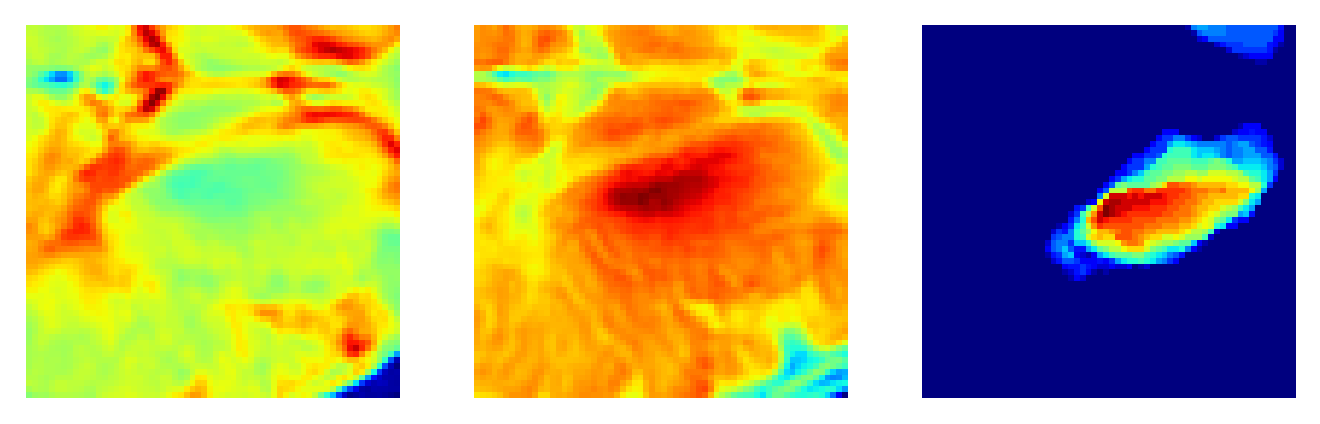

image shape: torch.Size([64, 64, 32])
image shape: torch.Size([64, 64, 32])


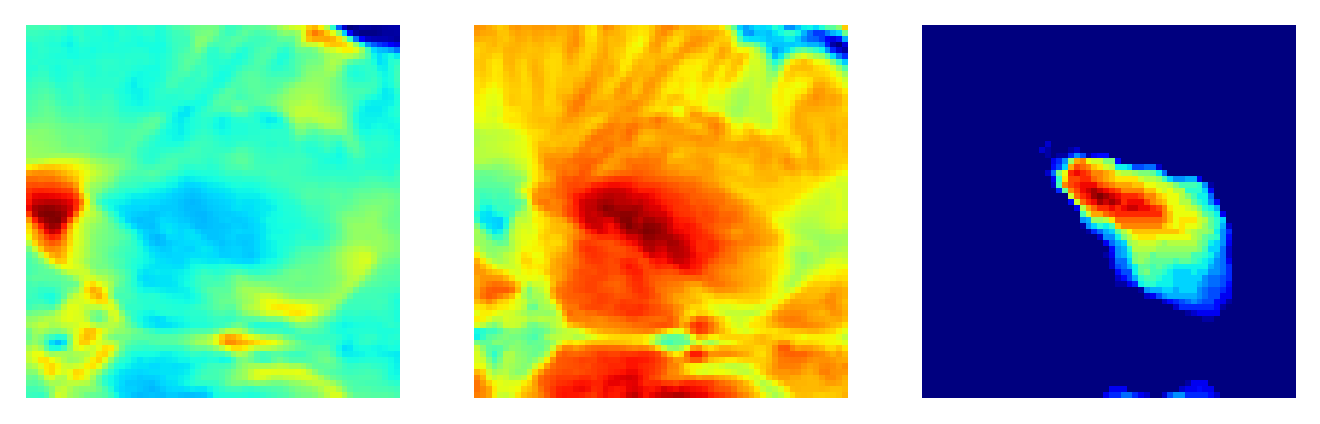

image shape: torch.Size([64, 64, 32])
image shape: torch.Size([64, 64, 32])


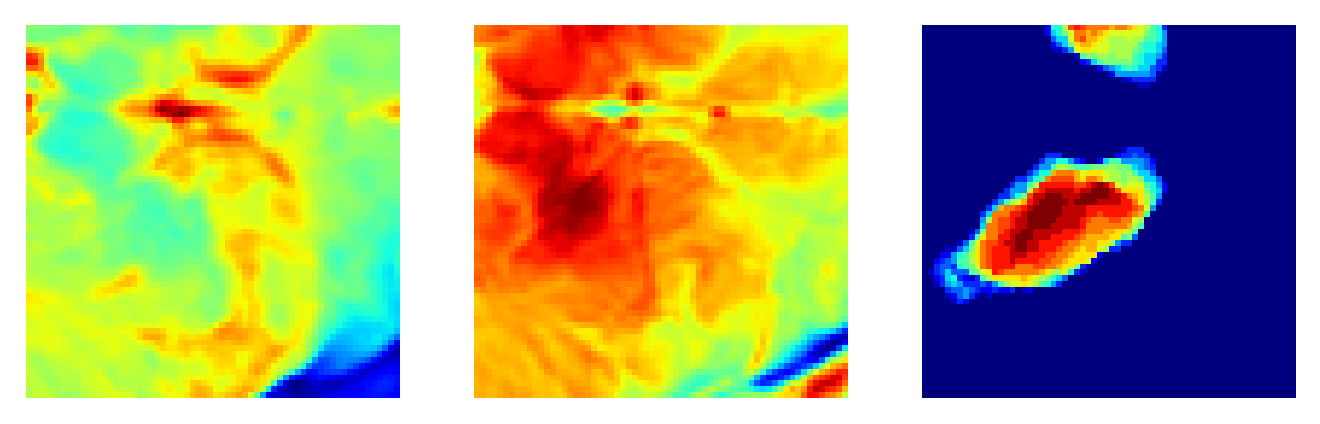

In [13]:
for N in range(len(check_data["image1"])):
    pre1 = (check_data["image1"][N][0])
    pre2 = (check_data["image2"][N][0])
    seg = (check_data["seg"][N][0])
    print(f"image shape: {pre1.shape}")
    print(f"image shape: {pre2.shape}")
    
    plt.figure(dpi=256)
    plt.subplot(131)
    plt.imshow(torch.sum(pre1,axis=2),cmap='jet')
    # plt.imshow(pre[:,:,16],cmap='jet')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(torch.sum(pre2,axis=2),cmap='jet')
    # plt.imshow(seg[:,:,16],cmap='jet')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(torch.sum(seg,axis=2),cmap='jet')
    # plt.imshow(seg[:,:,16],cmap='jet')
    plt.axis('off')
    plt.axis('off')
    plt.show()

In [14]:
train_ds = CacheDataset(
    data=train_data[:],
    transform=train_transforms,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True,
)

Loading dataset:   3%|▊                          | 1/32 [00:00<00:19,  1.63it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:   6%|█▋                         | 2/32 [00:01<00:17,  1.68it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:   9%|██▌                        | 3/32 [00:01<00:17,  1.68it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  12%|███▍                       | 4/32 [00:02<00:16,  1.69it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  16%|████▏                      | 5/32 [00:02<00:16,  1.68it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  19%|█████                      | 6/32 [00:03<00:15,  1.66it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  22%|█████▉                     | 7/32 [00:04<00:14,  1.67it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  25%|██████▊                    | 8/32 [00:04<00:14,  1.68it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  28%|███████▌                   | 9/32 [00:05<00:13,  1.68it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  31%|████████▏                 | 10/32 [00:05<00:13,  1.67it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  34%|████████▉                 | 11/32 [00:06<00:12,  1.66it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  38%|█████████▊                | 12/32 [00:07<00:12,  1.64it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  41%|██████████▌               | 13/32 [00:07<00:11,  1.63it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  44%|███████████▍              | 14/32 [00:08<00:11,  1.62it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  47%|████████████▏             | 15/32 [00:09<00:10,  1.62it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  50%|█████████████             | 16/32 [00:09<00:09,  1.62it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  53%|█████████████▊            | 17/32 [00:10<00:09,  1.63it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  56%|██████████████▋           | 18/32 [00:10<00:08,  1.63it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  59%|███████████████▍          | 19/32 [00:11<00:08,  1.62it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  62%|████████████████▎         | 20/32 [00:12<00:07,  1.62it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  66%|█████████████████         | 21/32 [00:12<00:06,  1.62it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  69%|█████████████████▉        | 22/32 [00:13<00:06,  1.63it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  72%|██████████████████▋       | 23/32 [00:13<00:05,  1.63it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  75%|███████████████████▌      | 24/32 [00:14<00:04,  1.62it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  78%|████████████████████▎     | 25/32 [00:15<00:04,  1.62it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  81%|█████████████████████▏    | 26/32 [00:15<00:03,  1.63it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  84%|█████████████████████▉    | 27/32 [00:16<00:03,  1.62it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  88%|██████████████████████▊   | 28/32 [00:17<00:02,  1.61it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  91%|███████████████████████▌  | 29/32 [00:17<00:01,  1.61it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  94%|████████████████████████▍ | 30/32 [00:18<00:01,  1.59it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  97%|█████████████████████████▏| 31/32 [00:18<00:00,  1.60it/s]

torch.Size([1, 208, 320, 320])


Loading dataset: 100%|██████████████████████████| 32/32 [00:19<00:00,  1.63it/s]

torch.Size([1, 208, 320, 320])


In [15]:
val_ds = CacheDataset(
    data=val_data[:],
    transform=val_transforms,
)

valid_loader = DataLoader(
    val_ds, batch_size=1, shuffle=True, 
)

Loading dataset:  12%|███▌                        | 1/8 [00:00<00:04,  1.70it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  25%|███████                     | 2/8 [00:01<00:03,  1.72it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  38%|██████████▌                 | 3/8 [00:01<00:02,  1.70it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  50%|██████████████              | 4/8 [00:02<00:02,  1.68it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  62%|█████████████████▌          | 5/8 [00:02<00:01,  1.67it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  75%|█████████████████████       | 6/8 [00:03<00:01,  1.66it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  88%|████████████████████████▌   | 7/8 [00:04<00:00,  1.68it/s]

torch.Size([1, 208, 320, 320])


Loading dataset: 100%|████████████████████████████| 8/8 [00:04<00:00,  1.68it/s]

torch.Size([1, 208, 320, 320])


In [16]:
# import Swinunetr as Swin

In [17]:
# device= "cuda:0"
# model = Swin.SwinUNETR(img_size=(96,96,32), in_channels=2, out_channels=2, feature_size=48).to(device)
# model

In [18]:
import cm_dual_encoder_sur as cm

In [19]:
device= "cuda:0"
model = cm.Dual_SwinUNETR(img_size=(64,64,32), in_channels=1, out_channels=2, feature_size=48).to(device)
model

Dual_SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(1, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=48, out_features=192, bias=True)
              (linear2): Linear(in_fe

In [20]:
from monai.losses import HausdorffDTLoss

In [21]:
# loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
loss_function = HausdorffDTLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True

In [22]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs_T2,val_inputs_SWI, val_labels = (batch["image1"]).to(device),(batch["image2"]).to(device), batch["seg"].to(device)
            val_inputs = torch.cat((val_inputs_T2,val_inputs_SWI),axis=1)
            val_outputs = model(val_inputs_T2, val_inputs_SWI)
            
            
            # val_single_label = (val_labels == 3).to(val_labels.dtype)
                      
            if step==0:
                # plt.figure(dpi=256)
                # plt.subplot(161)
                # plt.imshow(val_inputs[0,0,:,:,16].cpu(),cmap='gray')
                # plt.axis('off')
                # plt.title('input')
                # plt.subplot(162)
                # plt.imshow(val_outputs[0,0,:,:,16].cpu(),cmap='jet')
                # plt.axis('off')
                # plt.title('background')
                # plt.subplot(163)
                # plt.imshow(val_outputs[0,1,:,:,16].cpu(),cmap='jet')
                # plt.axis('off')
                # plt.title('BG')
                # plt.subplot(164)
                # plt.imshow(val_labels[0,0,:,:,16].cpu(),cmap='jet')
                # plt.axis('off')
                # plt.title('label')
                plt.figure(dpi=256)
                plt.subplot(161)
                plt.imshow(torch.rot90(torch.sum(val_inputs[0,0,:,:,:].detach().cpu(),dim=2)),cmap='gray')
                plt.axis('off')
                plt.title('input')
                plt.subplot(162)
                plt.imshow(torch.rot90(torch.sum(val_outputs[0,0,:,:,:].detach().cpu()>.5,dim=2)),cmap='jet')
                plt.axis('off')
                plt.title('background')
                plt.subplot(163)
                plt.imshow(torch.rot90(torch.sum(val_outputs[0,1,:,:,:].detach().cpu()>.5,dim=2)),cmap='jet')
                plt.axis('off')
                plt.title('BG')
                plt.subplot(164)
                plt.imshow(torch.rot90(torch.sum(val_labels[0,0,:,:,:].detach().cpu()>.5,dim=2)),cmap='jet')
                plt.axis('off')
                plt.title('label')
                # plt.subplot(166)
                # plt.plot(epoch_loss_values, label='Loss Curve')
                # plt.xlabel('Epoch')
                # plt.ylabel('Loss')
                # plt.legend()       
                plt.show()          
            
            val_labels_list = decollate_batch(val_labels)#변수를 개별 레이블 텐서 목록으로 분할
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
                  
    dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val

In [23]:
def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        a, b, y = batch["image1"].to(device), batch["image2"].to(device), batch["seg"].to(device)
        x = torch.cat((a, b),axis=1)
                        
        ##training
        logit_map = model(a, b)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        loss_values.append(loss.item()) # 전체 loss 보기위해 새로 추가
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        ##validaiotn 
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                valid_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if (dice_val > dice_val_best) & (dice_val < 1.0): # best parameter 뽑기 위해
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join( f"T2,SWI_new_model_hausdorff_best_vxxxx_{global_step}.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1

#    scheduler.step()

    return global_step, dice_val_best, global_step_best

In [24]:
max_iterations = 1000
eval_num = 100
post_label = AsDiscrete(to_onehot=2)
post_pred = AsDiscrete(argmax=True, to_onehot=2)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.85
global_step_best = 0
epoch_loss_values = []
metric_values = []
loss_values = [] # 새로 추가해줌 (전체 loss 보려고)
#optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [25]:
model.load_state_dict(torch.load("T2,SWI_newmodel_hausdorff_last_vxxxx_1024.pth"))

<All keys matched successfully>

Training (31 / 1000 Steps) (loss=0.20007): 100%|█| 32/32 [01:23<00:00,  2.62s/it
Training (63 / 1000 Steps) (loss=0.17480): 100%|█| 32/32 [00:33<00:00,  1.05s/it
Training (95 / 1000 Steps) (loss=0.17655): 100%|█| 32/32 [00:33<00:00,  1.05s/it
Training (100 / 1000 Steps) (loss=0.14510):  12%|▏| 4/32 [00:05<00:29,  1.05s/it
Validate (X / X Steps) (dice=X.X):   0%|                  | 0/8 [00:00<?, ?it/s]

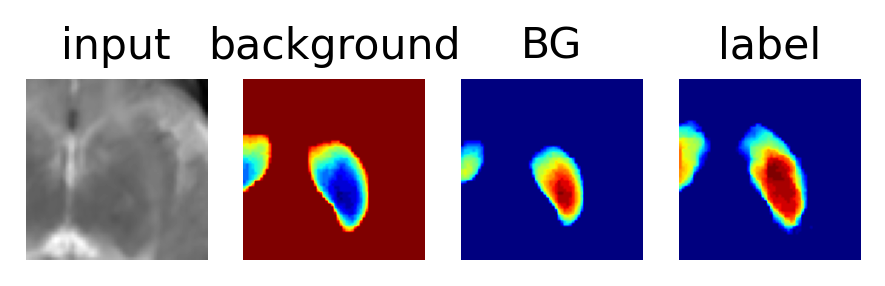


Validate (96 / 10 Steps) (dice=0.87980): 100%|████| 8/8 [00:02<00:00,  2.77it/s]
Training (100 / 1000 Steps) (loss=0.14510):  16%|▏| 5/32 [00:08<01:01,  2.30s/it

Model Was Saved ! Current Best Avg. Dice: 0.8756857663393021 Current Avg. Dice: 0.8756857663393021


Training (127 / 1000 Steps) (loss=0.20412): 100%|█| 32/32 [00:37<00:00,  1.16s/i
Training (159 / 1000 Steps) (loss=0.04909): 100%|█| 32/32 [00:33<00:00,  1.05s/i
Training (191 / 1000 Steps) (loss=0.09426): 100%|█| 32/32 [00:33<00:00,  1.05s/i
Training (200 / 1000 Steps) (loss=0.05850):  25%|▎| 8/32 [00:09<00:25,  1.05s/it
Validate (X / X Steps) (dice=X.X):   0%|                  | 0/8 [00:00<?, ?it/s]

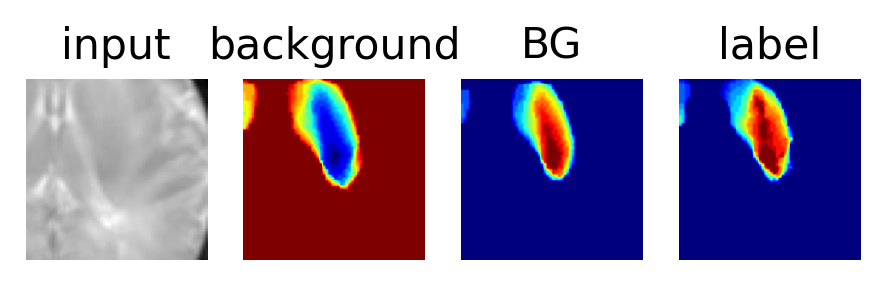


Validate (192 / 10 Steps) (dice=0.91499): 100%|███| 8/8 [00:02<00:00,  2.75it/s]
Training (200 / 1000 Steps) (loss=0.05850):  28%|▎| 9/32 [00:12<00:49,  2.14s/it

Model Was Saved ! Current Best Avg. Dice: 0.9170583784580231 Current Avg. Dice: 0.9170583784580231


Training (223 / 1000 Steps) (loss=0.19702): 100%|█| 32/32 [00:37<00:00,  1.17s/i
Training (255 / 1000 Steps) (loss=0.07859): 100%|█| 32/32 [00:33<00:00,  1.05s/i
Training (287 / 1000 Steps) (loss=0.10883): 100%|█| 32/32 [00:33<00:00,  1.05s/i
Training (300 / 1000 Steps) (loss=0.40215):  38%|▍| 12/32 [00:13<00:20,  1.05s/i
Validate (X / X Steps) (dice=X.X):   0%|                  | 0/8 [00:00<?, ?it/s]

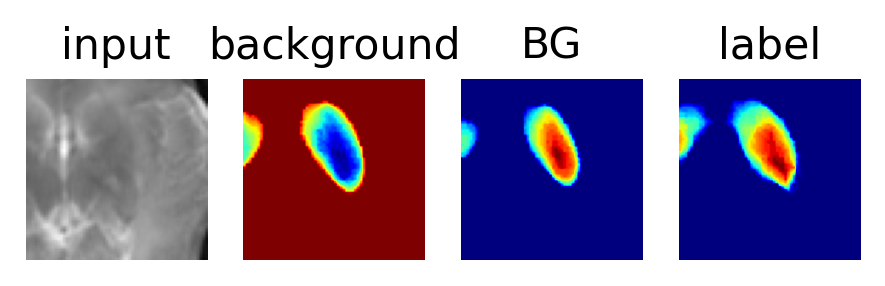


Validate (288 / 10 Steps) (dice=0.90334): 100%|███| 8/8 [00:02<00:00,  2.79it/s]
Training (300 / 1000 Steps) (loss=0.40215):  41%|▍| 13/32 [00:16<00:36,  1.92s/i

Model Was Not Saved ! Current Best Avg. Dice: 0.9170583784580231 Current Avg. Dice: 0.9057500660419464


Training (319 / 1000 Steps) (loss=0.07475): 100%|█| 32/32 [00:36<00:00,  1.14s/i
Training (351 / 1000 Steps) (loss=0.08496): 100%|█| 32/32 [00:33<00:00,  1.06s/i
Training (383 / 1000 Steps) (loss=0.11870): 100%|█| 32/32 [00:33<00:00,  1.05s/i
Training (400 / 1000 Steps) (loss=0.13055):  50%|▌| 16/32 [00:17<00:16,  1.05s/i
Validate (X / X Steps) (dice=X.X):   0%|                  | 0/8 [00:00<?, ?it/s]

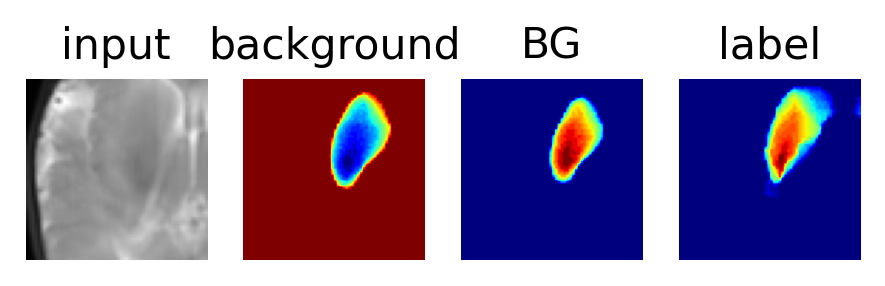


Validate (384 / 10 Steps) (dice=0.89697): 100%|███| 8/8 [00:02<00:00,  2.80it/s]
Training (400 / 1000 Steps) (loss=0.13055):  53%|▌| 17/32 [00:20<00:28,  1.91s/i

Model Was Not Saved ! Current Best Avg. Dice: 0.9170583784580231 Current Avg. Dice: 0.8891849294304848


Training (415 / 1000 Steps) (loss=0.06315): 100%|█| 32/32 [00:36<00:00,  1.14s/i
Training (447 / 1000 Steps) (loss=0.07089): 100%|█| 32/32 [00:33<00:00,  1.05s/i
Training (479 / 1000 Steps) (loss=0.04120): 100%|█| 32/32 [00:33<00:00,  1.05s/i
Training (500 / 1000 Steps) (loss=0.08604):  62%|▋| 20/32 [00:22<00:12,  1.06s/i
Validate (X / X Steps) (dice=X.X):   0%|                  | 0/8 [00:00<?, ?it/s]

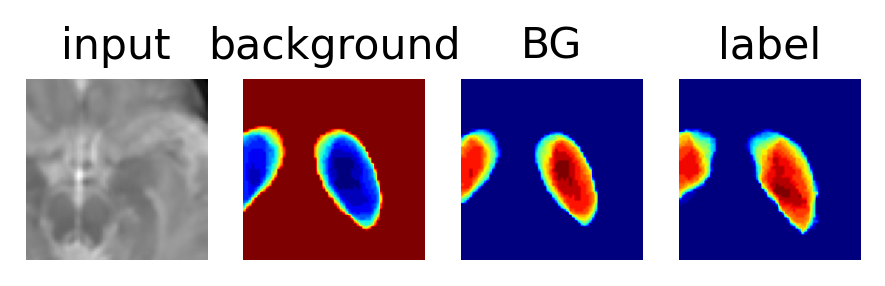


Validate (480 / 10 Steps) (dice=0.91264): 100%|███| 8/8 [00:02<00:00,  2.77it/s]
Training (500 / 1000 Steps) (loss=0.08604):  66%|▋| 21/32 [00:24<00:21,  1.93s/i

Model Was Not Saved ! Current Best Avg. Dice: 0.9170583784580231 Current Avg. Dice: 0.9134047850966454


Training (511 / 1000 Steps) (loss=0.10504): 100%|█| 32/32 [00:36<00:00,  1.14s/i
Training (543 / 1000 Steps) (loss=0.10548): 100%|█| 32/32 [00:33<00:00,  1.05s/i
Training (575 / 1000 Steps) (loss=0.12512): 100%|█| 32/32 [00:33<00:00,  1.05s/i
Training (600 / 1000 Steps) (loss=0.15587):  75%|▊| 24/32 [00:26<00:08,  1.06s/i
Validate (X / X Steps) (dice=X.X):   0%|                  | 0/8 [00:00<?, ?it/s]

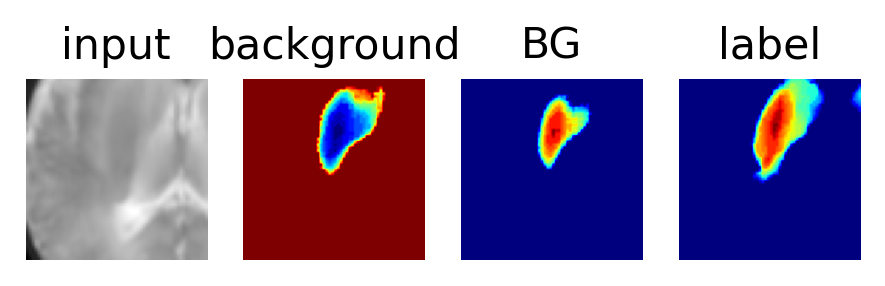


Validate (576 / 10 Steps) (dice=0.84127): 100%|███| 8/8 [00:02<00:00,  2.81it/s]
Training (600 / 1000 Steps) (loss=0.15587):  78%|▊| 25/32 [00:29<00:13,  1.91s/i

Model Was Not Saved ! Current Best Avg. Dice: 0.9170583784580231 Current Avg. Dice: 0.8408776074647903


Training (607 / 1000 Steps) (loss=0.24303): 100%|█| 32/32 [00:36<00:00,  1.14s/i
Training (639 / 1000 Steps) (loss=0.07075): 100%|█| 32/32 [00:33<00:00,  1.05s/i
Training (671 / 1000 Steps) (loss=0.16357): 100%|█| 32/32 [00:33<00:00,  1.05s/i
Training (700 / 1000 Steps) (loss=0.12181):  88%|▉| 28/32 [00:30<00:04,  1.05s/i
Validate (X / X Steps) (dice=X.X):   0%|                  | 0/8 [00:00<?, ?it/s]

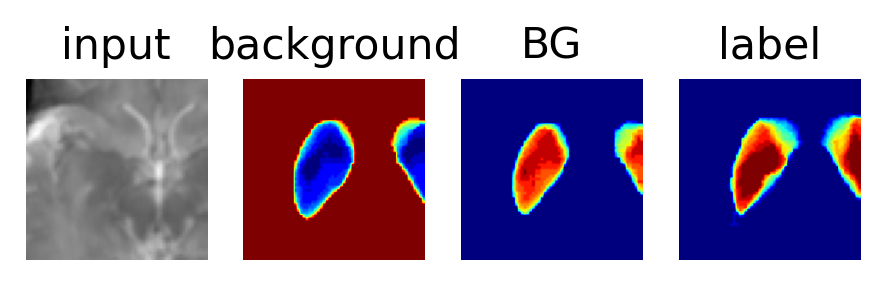


Validate (672 / 10 Steps) (dice=0.90627): 100%|███| 8/8 [00:02<00:00,  2.79it/s]
Training (700 / 1000 Steps) (loss=0.12181):  91%|▉| 29/32 [00:33<00:05,  1.91s/i

Model Was Not Saved ! Current Best Avg. Dice: 0.9170583784580231 Current Avg. Dice: 0.9085956364870071


Training (703 / 1000 Steps) (loss=0.06550): 100%|█| 32/32 [00:36<00:00,  1.14s/i
Training (735 / 1000 Steps) (loss=0.04386): 100%|█| 32/32 [00:33<00:00,  1.05s/i
Training (767 / 1000 Steps) (loss=0.08699): 100%|█| 32/32 [00:33<00:00,  1.05s/i
Training (799 / 1000 Steps) (loss=0.12313): 100%|█| 32/32 [00:33<00:00,  1.05s/i
Validate (X / X Steps) (dice=X.X):   0%|                  | 0/8 [00:00<?, ?it/s]

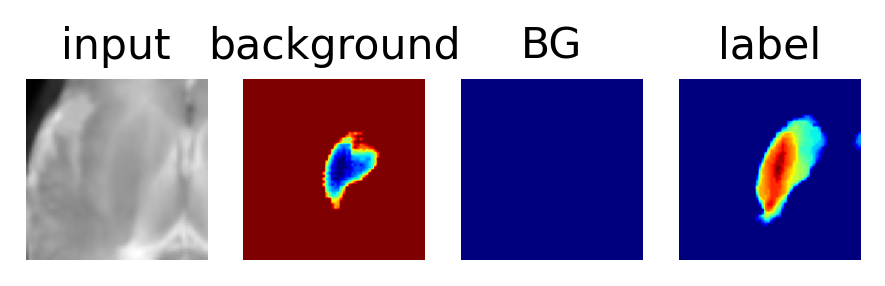


Validate (800 / 10 Steps) (dice=0.65007): 100%|███| 8/8 [00:02<00:00,  2.79it/s]
Training (800 / 1000 Steps) (loss=0.31579):   3%| | 1/32 [00:03<02:01,  3.92s/it

Model Was Not Saved ! Current Best Avg. Dice: 0.9170583784580231 Current Avg. Dice: 0.618799664080143


Training (831 / 1000 Steps) (loss=0.25094): 100%|█| 32/32 [00:36<00:00,  1.14s/i
Training (863 / 1000 Steps) (loss=0.18905): 100%|█| 32/32 [00:33<00:00,  1.05s/i
Training (895 / 1000 Steps) (loss=0.07785): 100%|█| 32/32 [00:33<00:00,  1.05s/i
Training (900 / 1000 Steps) (loss=0.11136):  12%|▏| 4/32 [00:05<00:29,  1.04s/it
Validate (X / X Steps) (dice=X.X):   0%|                  | 0/8 [00:00<?, ?it/s]

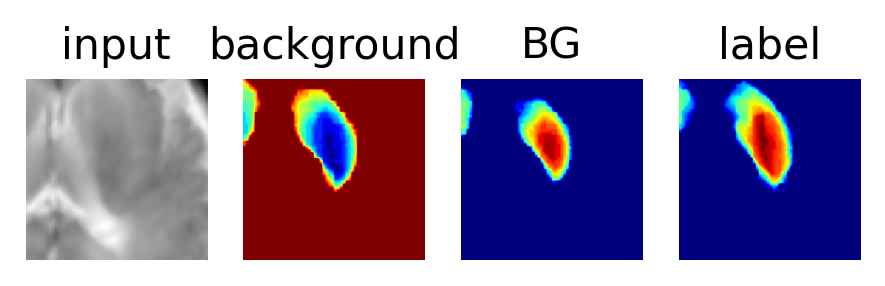


Validate (896 / 10 Steps) (dice=0.87593): 100%|███| 8/8 [00:02<00:00,  2.77it/s]
Training (900 / 1000 Steps) (loss=0.11136):  16%|▏| 5/32 [00:08<00:56,  2.09s/it

Model Was Not Saved ! Current Best Avg. Dice: 0.9170583784580231 Current Avg. Dice: 0.8784734755754471


Training (927 / 1000 Steps) (loss=0.06598): 100%|█| 32/32 [00:36<00:00,  1.14s/i
Training (959 / 1000 Steps) (loss=0.09170): 100%|█| 32/32 [00:33<00:00,  1.05s/i
Training (991 / 1000 Steps) (loss=0.90632): 100%|█| 32/32 [00:33<00:00,  1.05s/i
Training (1000 / 1000 Steps) (loss=0.12565):  25%|▎| 8/32 [00:09<00:25,  1.05s/i
Validate (X / X Steps) (dice=X.X):   0%|                  | 0/8 [00:00<?, ?it/s]

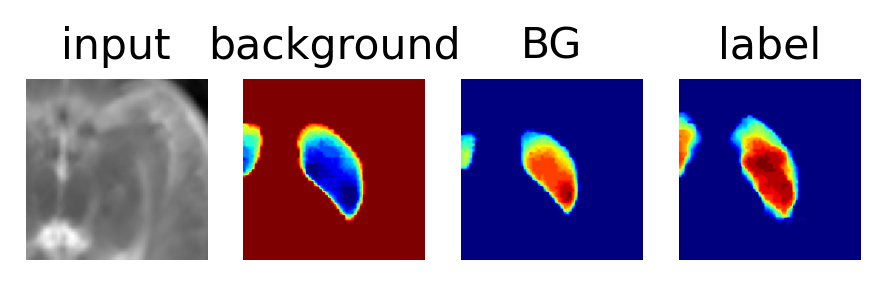


Validate (992 / 10 Steps) (dice=0.89765): 100%|███| 8/8 [00:02<00:00,  2.78it/s]
Training (1000 / 1000 Steps) (loss=0.12565):  28%|▎| 9/32 [00:12<00:44,  1.95s/i

Model Was Not Saved ! Current Best Avg. Dice: 0.9170583784580231 Current Avg. Dice: 0.8897895440459251


Training (1023 / 1000 Steps) (loss=0.10458): 100%|█| 32/32 [00:36<00:00,  1.14s/


In [26]:
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )

torch.save(model.state_dict(), os.path.join( f"T2,SWI_newmodel_hausdorff_last_vxxxx_{global_step}.pth"))

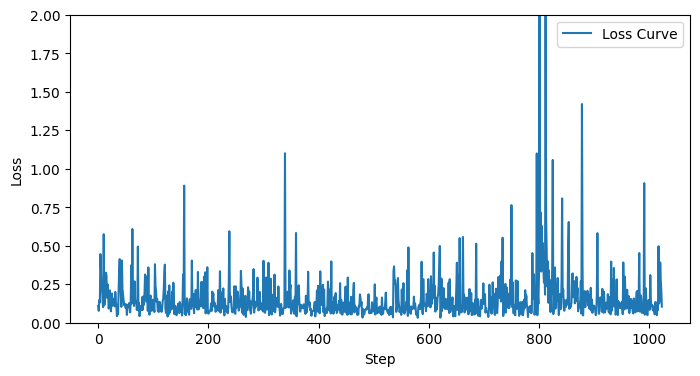

In [28]:
plt.figure(figsize=(8, 4))
plt.plot(loss_values, label='Loss Curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 2)

plt.savefig('/home/oem/hufsbaby/joon/Brain_segmentation_0731/new_model_T2,SWI_loss_4500_3500_4500_var.png')
plt.show()

In [29]:
global_step

1024

In [2]:
# input_RS = []
# for i in df_idx_list:
#     p = df.iloc[i,0]
#     if i in test_list:
#         input_RS.append(p)
        
# print(input_RS)

In [3]:
# test_data = [
#     {
#         "image1": os.path.join(data_Root,str(idx)+'/'+
#                                     "T2_r1.nii.gz"),
#         "seg": os.path.join(data_Root,str(idx)+'/'+
#                                     "wmbg_cx.nii.gz"),            
#     }
#     for idx in input_RS
# ]

In [4]:
# print(len(test_data))
# test_data

In [26]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image1", "image2", "seg"]),
        EnsureChannelFirstd(keys=["image1", "image2", "seg"]),  
        ConvertToOneCLass(keys = ["seg"]), # 위에서 정의한 class 
        CropForegroundd(keys = ["image1", "image2","seg"], source_key = "seg", margin = (15, 30, 5)), ######## mask 중심으로 crop
        ToTensord(keys=["image1", "image2", "seg"]),
    ]
)

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


Loading dataset:  12%|███▌                        | 1/8 [00:00<00:04,  1.62it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  25%|███████                     | 2/8 [00:01<00:03,  1.62it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  38%|██████████▌                 | 3/8 [00:01<00:03,  1.60it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  50%|██████████████              | 4/8 [00:02<00:02,  1.57it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  62%|█████████████████▌          | 5/8 [00:03<00:01,  1.57it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  75%|█████████████████████       | 6/8 [00:03<00:01,  1.62it/s]

torch.Size([1, 208, 320, 320])


Loading dataset:  88%|████████████████████████▌   | 7/8 [00:04<00:00,  1.66it/s]

torch.Size([1, 208, 320, 320])


Loading dataset: 100%|████████████████████████████| 8/8 [00:04<00:00,  1.64it/s]

torch.Size([1, 208, 320, 320])


image shape: torch.Size([93, 97, 41])
image shape: torch.Size([93, 97, 41])


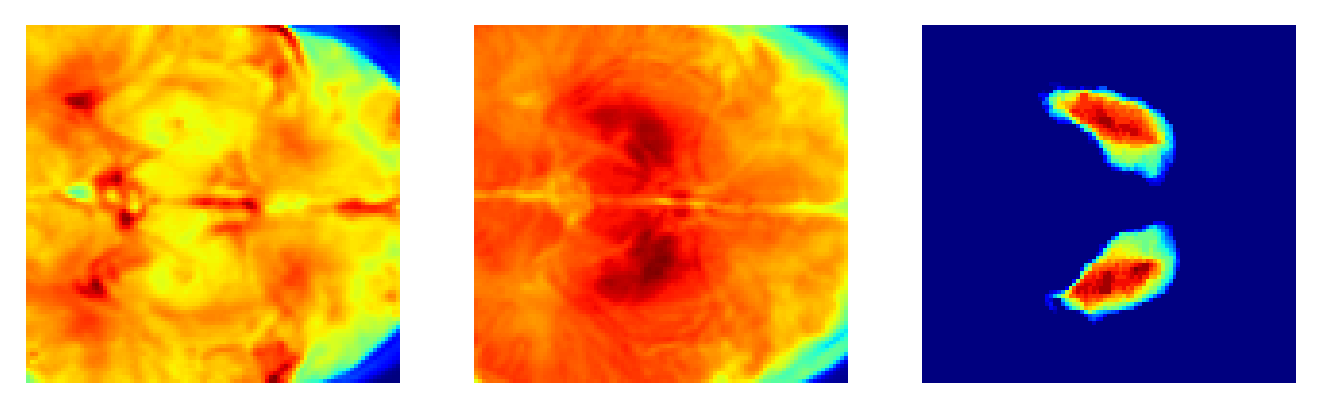

In [36]:
check_ds2 = CacheDataset(data=val_data, transform = test_transforms)
check_loader2 = DataLoader(check_ds2, batch_size=1, num_workers = 4)
check_data2 = first(check_loader2)

for N in range(len(check_data2["image1"])):
    pre1 = (check_data2["image1"][N][0])
    pre2 = (check_data2["image2"][N][0])
    seg = (check_data2["seg"][N][0])

    print(f"image shape: {pre1.shape}")
    print(f"image shape: {pre2.shape}")
    
    plt.figure(dpi=256)
    plt.subplot(131)
    plt.imshow(torch.sum(pre1,axis=2),cmap='jet')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(torch.sum(pre2,axis=2),cmap='jet')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(torch.sum(seg,axis=2),cmap='jet')
    plt.axis('off')
    plt.show()

In [28]:
test_ds = Dataset(
    data=val_data,
    transform=test_transforms,
)

In [29]:
test_loader = DataLoader(
    test_ds, batch_size=1, shuffle=False, 
)

In [30]:
from monai.inferers import sliding_window_inference
import nibabel as nib

In [31]:
# from collections import OrderedDict
# device = 'cuda:0'
# model = monai.networks.nets.SwinUNETR(img_size=(96,96,32), in_channels=1, out_channels=2, feature_size=48).to(device)
# loaded_state_dict = torch.load('/home/oem/hufsbaby/joon/Brain(0731)/SingleBrain_T2_model_last_vxxxx_9024.pth')
# current_state_dict = model.state_dict()
# current_state_dict.update(loaded_state_dict)
# # model.load_state_dict(current_state_dict)
# #model.load_state_dict('./SingleBrain_model_best_vxxxx.pth')

<All keys matched successfully>

In [31]:
# model.eval()
# with torch.no_grad():
#     for idx, batch in enumerate(check_loader2):
#         test_inputs = batch['image1'].to(device)
#         GT = batch['seg'].to(device)
#         test_outputs = sliding_window_inference(test_inputs, (64,64,32), 2, model, overlap=0.5,mode='gaussian').softmax(1)
#         # print(test_outputs.unique())
#         label_0 = (test_outputs[0,0].detach().cpu()>0.95).astype(int) * 0
#         label_1 = (test_outputs[0,1].detach().cpu()>0.95).astype(int) * 1
#         test_outputs = torch.tensor((label_0 + label_1)[np.newaxis, np.newaxis])
#         # print(type(test_outputs))
        
#         pid = batch["image1_meta_dict"]['filename_or_obj'][0].split('/')[-1].split('_')[0]
#         # print(f"test_inputs shape : {test_inputs.shape}")
#         # print(f"GT(=label) shape : {GT.shape}")
#         # print(f"dl_outputs shape : {test_outputs.shape}")
        
#         plt.figure(dpi = 256)
#         plt.subplot(131)
#         plt.imshow(torch.rot90(test_inputs[0,0,:,160,:].detach().cpu()), cmap='gray')
#         plt.gca().set_title('image')
#         plt.axis('off')
#         plt.subplot(132)
#         plt.imshow(torch.rot90(GT[0,0,:,160,:].detach().cpu()), cmap='gray')
#         plt.gca().set_title('label')
#         plt.axis('off')
#         plt.subplot(133)
#         plt.imshow(torch.rot90(test_outputs[0,0,:,160,:].detach().cpu()), cmap='gray')
#         plt.gca().set_title('dl_output')
#         plt.axis('off')
#         plt.show()

    
        


In [32]:
# model.eval()
# dice_vals = list()
# with torch.no_grad():
#     for step, batch in enumerate(test_loader):
#         test_inputs = (batch["image1"]).to(device)
#         labels = batch['seg'].to(device)
#         test_outputs = sliding_window_inference(test_inputs, [96,96,32], 2, model, overlap=0.5,mode='gaussian')
        
#         pid = batch["image1_meta_dict"]['filename_or_obj'][0].split('/')[-1].split('_')[0]
              
#         test_outputs = test_outputs.softmax(1)
#         print(step,pid)
        
#         plt.figure(dpi = 256)
#         plt.subplot(141)
#         plt.imshow(torch.rot90(test_inputs[0,0,:,:,150].detach().cpu()),cmap='gray')
#         plt.title(pid)
#         plt.axis('off')
#         plt.subplot(142)
#         plt.imshow(torch.rot90(test_outputs[0,0,:,:,150].detach().cpu()),cmap='jet')
#         plt.title('Back')
#         plt.subplot(143)
#         plt.imshow(torch.rot90(test_outputs[0,1,:,:,150].detach().cpu()>.5),cmap='jet')
#         plt.title('BG')
#         plt.axis('off')  
#         plt.subplot(144)
#         plt.imshow(torch.rot90(labels[0,0,:,:,150].detach().cpu()>.5),cmap='jet')
#         plt.title('Labels')
#         plt.axis('off')        
#         plt.show()     

In [33]:
from monai.inferers import sliding_window_inference
from matplotlib.ticker import StrMethodFormatter

model.eval()
dice_test = list()
dice_scores = []

with torch.no_grad():
    for step, batch in enumerate(check_loader2):
        test_inputs_T2, test_inputs_SWI, test_seg = (batch["image1"]).to(device), (batch["image2"]).to(device), (batch['seg']).to(device)
#         test_inputs = torch.cat((test_inputs_T2,test_inputs_SWI),axis=1)
        test_outputs = sliding_window_inference(
            [test_inputs_T2, test_inputs_SWI], [64,64,32], 2, model, overlap=0.85,mode='gaussian')
                
        pid = batch["image1_meta_dict"]['filename_or_obj'][0].split('/')[-1].split('_')[0]
              
        test_outputs = test_outputs.softmax(1)
        print(step,pid)

        
#         val_labels_list = decollate_batch(test_seg)#변수를 개별 레이블 텐서 목록으로 분할
#         val_labels_convert = [
#             post_label(val_label_tensor) for val_label_tensor in val_labels_list
#         ]
#         val_outputs_list = decollate_batch(test_outputs)
        
#         val_output_convert = [
#             post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
#         ]
#         dice_metric(y_pred=val_output_convert, y=val_labels_convert)
#         dice = dice_metric.aggregate().item()
#         print(dice)
        
#         dice_scores.append(dice)
#         average_dice_score = sum(dice_scores) / len(dice_scores)
#         print("Average Dice Score:", average_dice_score)
        
        plt.subplot(151)
        plt.imshow(torch.rot90(torch.sum(test_inputs[0,0,:,:,:].detach().cpu(),dim=2)),cmap='gray')
        plt.title(pid)
        plt.axis('off')
        plt.subplot(152)
        plt.imshow(torch.rot90(torch.sum(test_outputs[0,0,:,:,:].detach().cpu()>.5,dim=2)),cmap='jet')
        plt.title('Back')
        plt.axis('off')
        plt.subplot(153)
        plt.imshow(torch.rot90(torch.sum(test_outputs[0,1,:,:,:].detach().cpu()>.5,dim=2)),cmap='jet')
        plt.title('BG')
        plt.axis('off')
        
        plt.show()
        
#         plt.boxplot(dice_scores, labels=['Dice Score'])
#         plt.title('T2 + SWI')
#         plt.ylabel('Dice Score')
#         plt.ylim(0.850, 0.950)
#         plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.3f}'))
#         plt.show()
        
    
        z = 11

        input_data = test_inputs[0, 0].cpu().numpy()  # 첫 번째 batch의 input_data 추출
        output_data = test_outputs[0, 0].cpu().numpy()  # 첫 번째 batch seg_data 추출

        print(input_data.shape)

        input_slice = np.rot90(input_data[:, :, z])
        output_slice = np.rot90(output_data[:, :, z])

        plt.figure(figsize=(5, 5))
        plt.imshow(input_slice, cmap='gray')
        plt.contour(output_slice, colors='blue', linewidths=0.3, linestyles='solid', extend='both',alpha=0.4)
        plt.axis('off')
        plt.show()
    
#         break
    
#         SWI = test_inputs[0, 0, :, :, :].detach().cpu()
#         SWI = SWI.numpy().astype(np.float32)  # Convert to numpy array and specify data type
#         nifti_img = nib.Nifti1Image(SWI, affine=np.eye(4))
#         nib.save(nifti_img, f'/home/oem/hufsbaby/joon/Brain_segmentation_0731/Result/T2,SWI_DICE{step}.nii.gz')
        
        
#         BG = test_outputs[0, 1, :, :, :].detach().cpu()
#         BG = BG.numpy().astype(np.float32)  # Convert to numpy array and specify data type
#         nifti_img = nib.Nifti1Image(BG, affine=np.eye(4))
#         nib.save(nifti_img, f'/home/oem/hufsbaby/joon/Brain_segmentation_0731/Result/BG_T2,SWI_DICE{step}.nii.gz')
        
        break
        
#         def dice_per_class(pred, target,):
#             # MONAI에서 DiceMetric을 사용하여 Dice 계수 계산
#             dice_metric = DiceMetric(include_background=False)

#             # PyTorch Tensor로 변환
#             pred_tensor = torch.tensor(pred).unsqueeze(0).float()
#             target_tensor = torch.tensor(target).unsqueeze(0).float()

#             # Dice 계수 계산
#             dice_metric(pred_tensor, target_tensor)

#             # DiceMetric은 클래스 별 Dice 계수를 반환하므로, 특정 클래스의 Dice 계수를 가져옵니다.
#             dice_score = dice_metric.aggregate()

#             return dice_score.item() 
        
        

AttributeError: 'list' object has no attribute 'shape'